In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import warnings
from secret import path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import skfuzzy as fuzz
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTETomek
warnings.filterwarnings("ignore")

In [2]:
# Loading our dataset in pandas libraries for analysis and data manipulation if needed
main_df = pd.read_csv(path+"\\creditcard.csv")
main_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
value_counts = main_df['Class'].value_counts()
# Access the counts for 0 and 1
count_0 = value_counts.get(0, 0)  # Get count of 0, default to 0 if not found
count_1 = value_counts.get(1, 0)  # Get count of 1, default to 0 if not found

print(f"Count of 0s: {count_0}")
print(f"Count of 1s: {count_1}")

Count of 0s: 284315
Count of 1s: 492


In [4]:
# Concise summary of data, including information about missing values and data types
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# Basic statistics for each numeric column, such as mean, min, max, etc
main_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
# Calculating the percentage of null/Nan values in our dataset.
(main_df[main_df.columns].isnull().sum()/main_df.shape[0])*100

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

# Shapiro-Wilk Test
- The Shapiro-Wilk test is a statistical test that checks if a dataset follows a normal distribution. A low p-value (typically less than 0.05) indicates that the data significantly deviates from a normal distribution.

In [7]:
from scipy.stats import shapiro

# Performing the Shapiro-Wilk test for each column in main_df
for column in main_df.columns:
    stat, p = shapiro(main_df[column])
    print(f'{column}: Statistics={stat}, p={p}')

Time: Statistics=0.9403074383735657, p=0.0
V1: Statistics=0.7989978194236755, p=0.0
V2: Statistics=0.7397158741950989, p=0.0
V3: Statistics=0.9079893827438354, p=0.0
V4: Statistics=0.9692802429199219, p=0.0
V5: Statistics=0.8248799443244934, p=0.0
V6: Statistics=0.8448642492294312, p=0.0
V7: Statistics=0.7248650193214417, p=0.0
V8: Statistics=0.49942588806152344, p=0.0
V9: Statistics=0.9693450331687927, p=0.0
V10: Statistics=0.8146618008613586, p=0.0
V11: Statistics=0.985582172870636, p=0.0
V12: Statistics=0.8836044073104858, p=0.0
V13: Statistics=0.9989896416664124, p=2.3147049526166136e-31
V14: Statistics=0.8843459486961365, p=0.0
V15: Statistics=0.9936365485191345, p=0.0
V16: Statistics=0.9505928754806519, p=0.0
V17: Statistics=0.7910325527191162, p=0.0
V18: Statistics=0.9847401976585388, p=0.0
V19: Statistics=0.9830102920532227, p=0.0
V20: Statistics=0.5296140909194946, p=0.0
V21: Statistics=0.48562562465667725, p=0.0
V22: Statistics=0.9829753041267395, p=0.0
V23: Statistics=0.4672

# Histograms
- Visualize the distribution of each feature using histograms. Normally distributed data should resemble a bell curve.

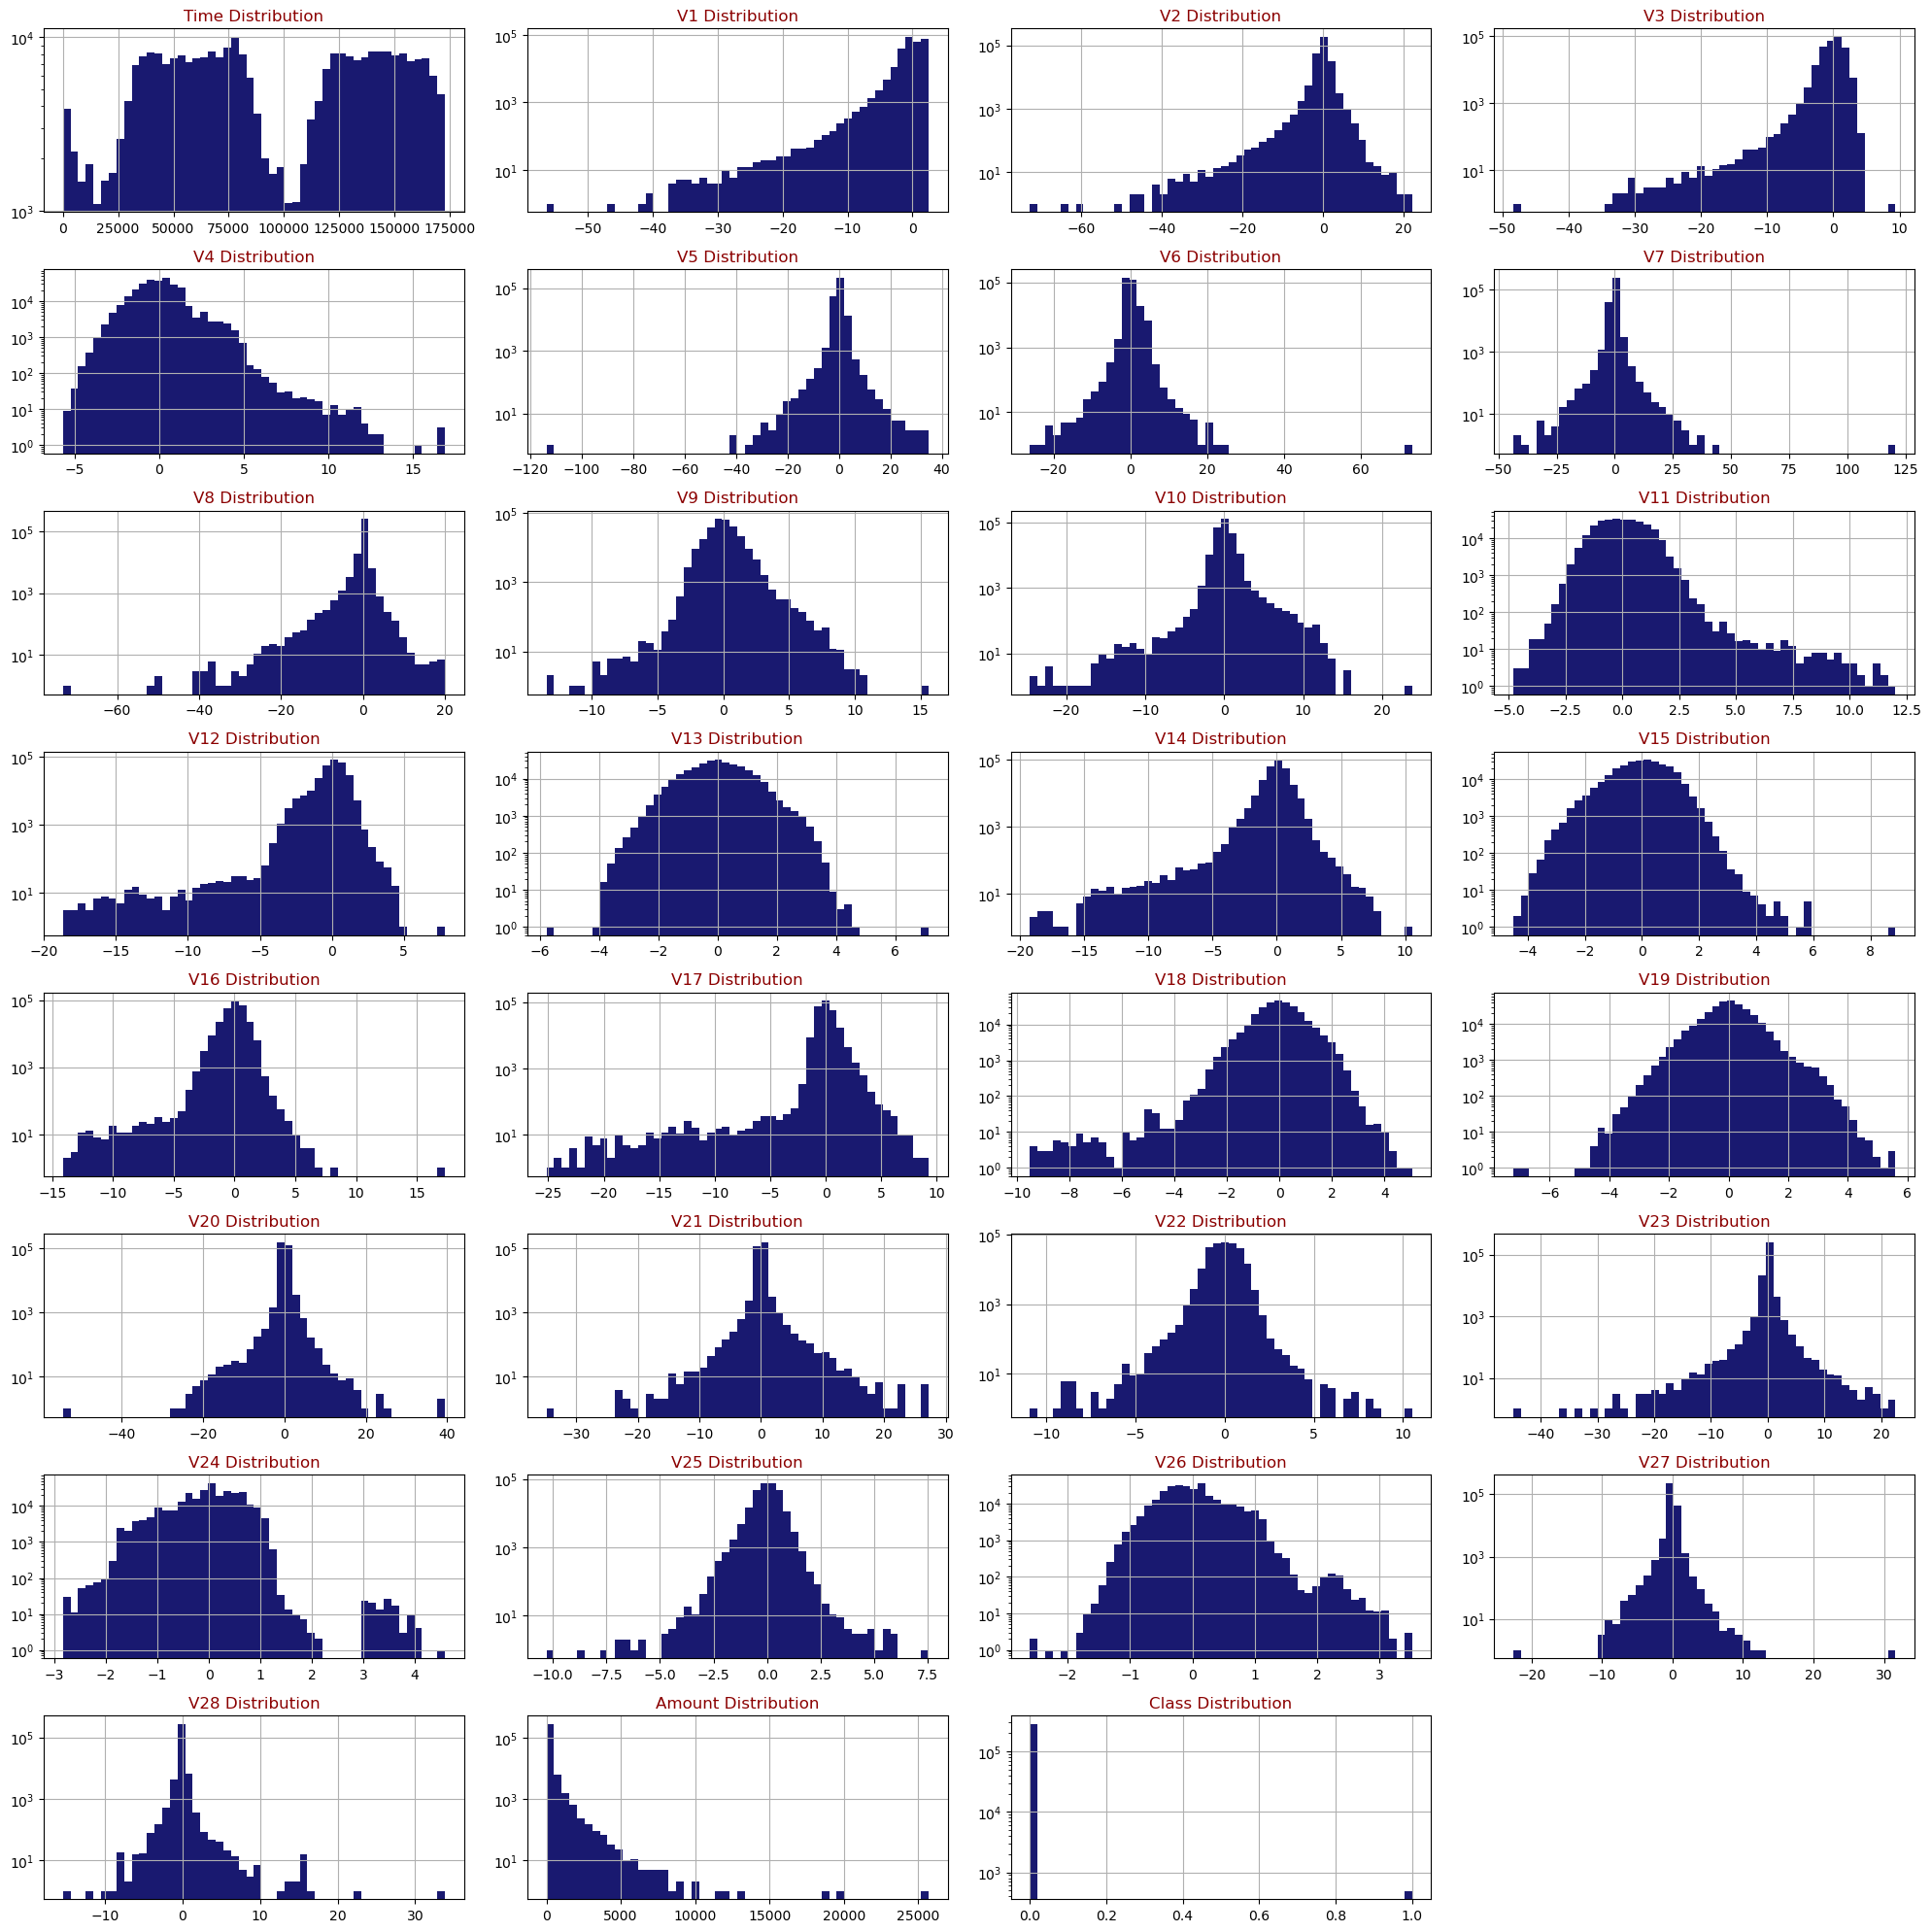

In [8]:
def draw_histograms(df, features, rows, columns):
    fig = plt.figure(figsize=(20, 20))
    for i, features in enumerate(features):
        ax = fig.add_subplot(rows, columns, i+1)
        df[features].hist(bins = 50 , ax = ax, facecolor='midnightblue')
        ax.set_title(features+" Distribution", color="DarkRed")
        ax.set_yscale('log')
    fig.tight_layout()
    plt.show()  
    
draw_histograms(main_df, main_df.columns, 8, 4)

# Q-Q Plots
- Quantile-quantile (Q-Q) plots compare the quantiles of your data to the quantiles of a theoretical normal distribution. Normally distributed data should roughly follow a diagonal line.

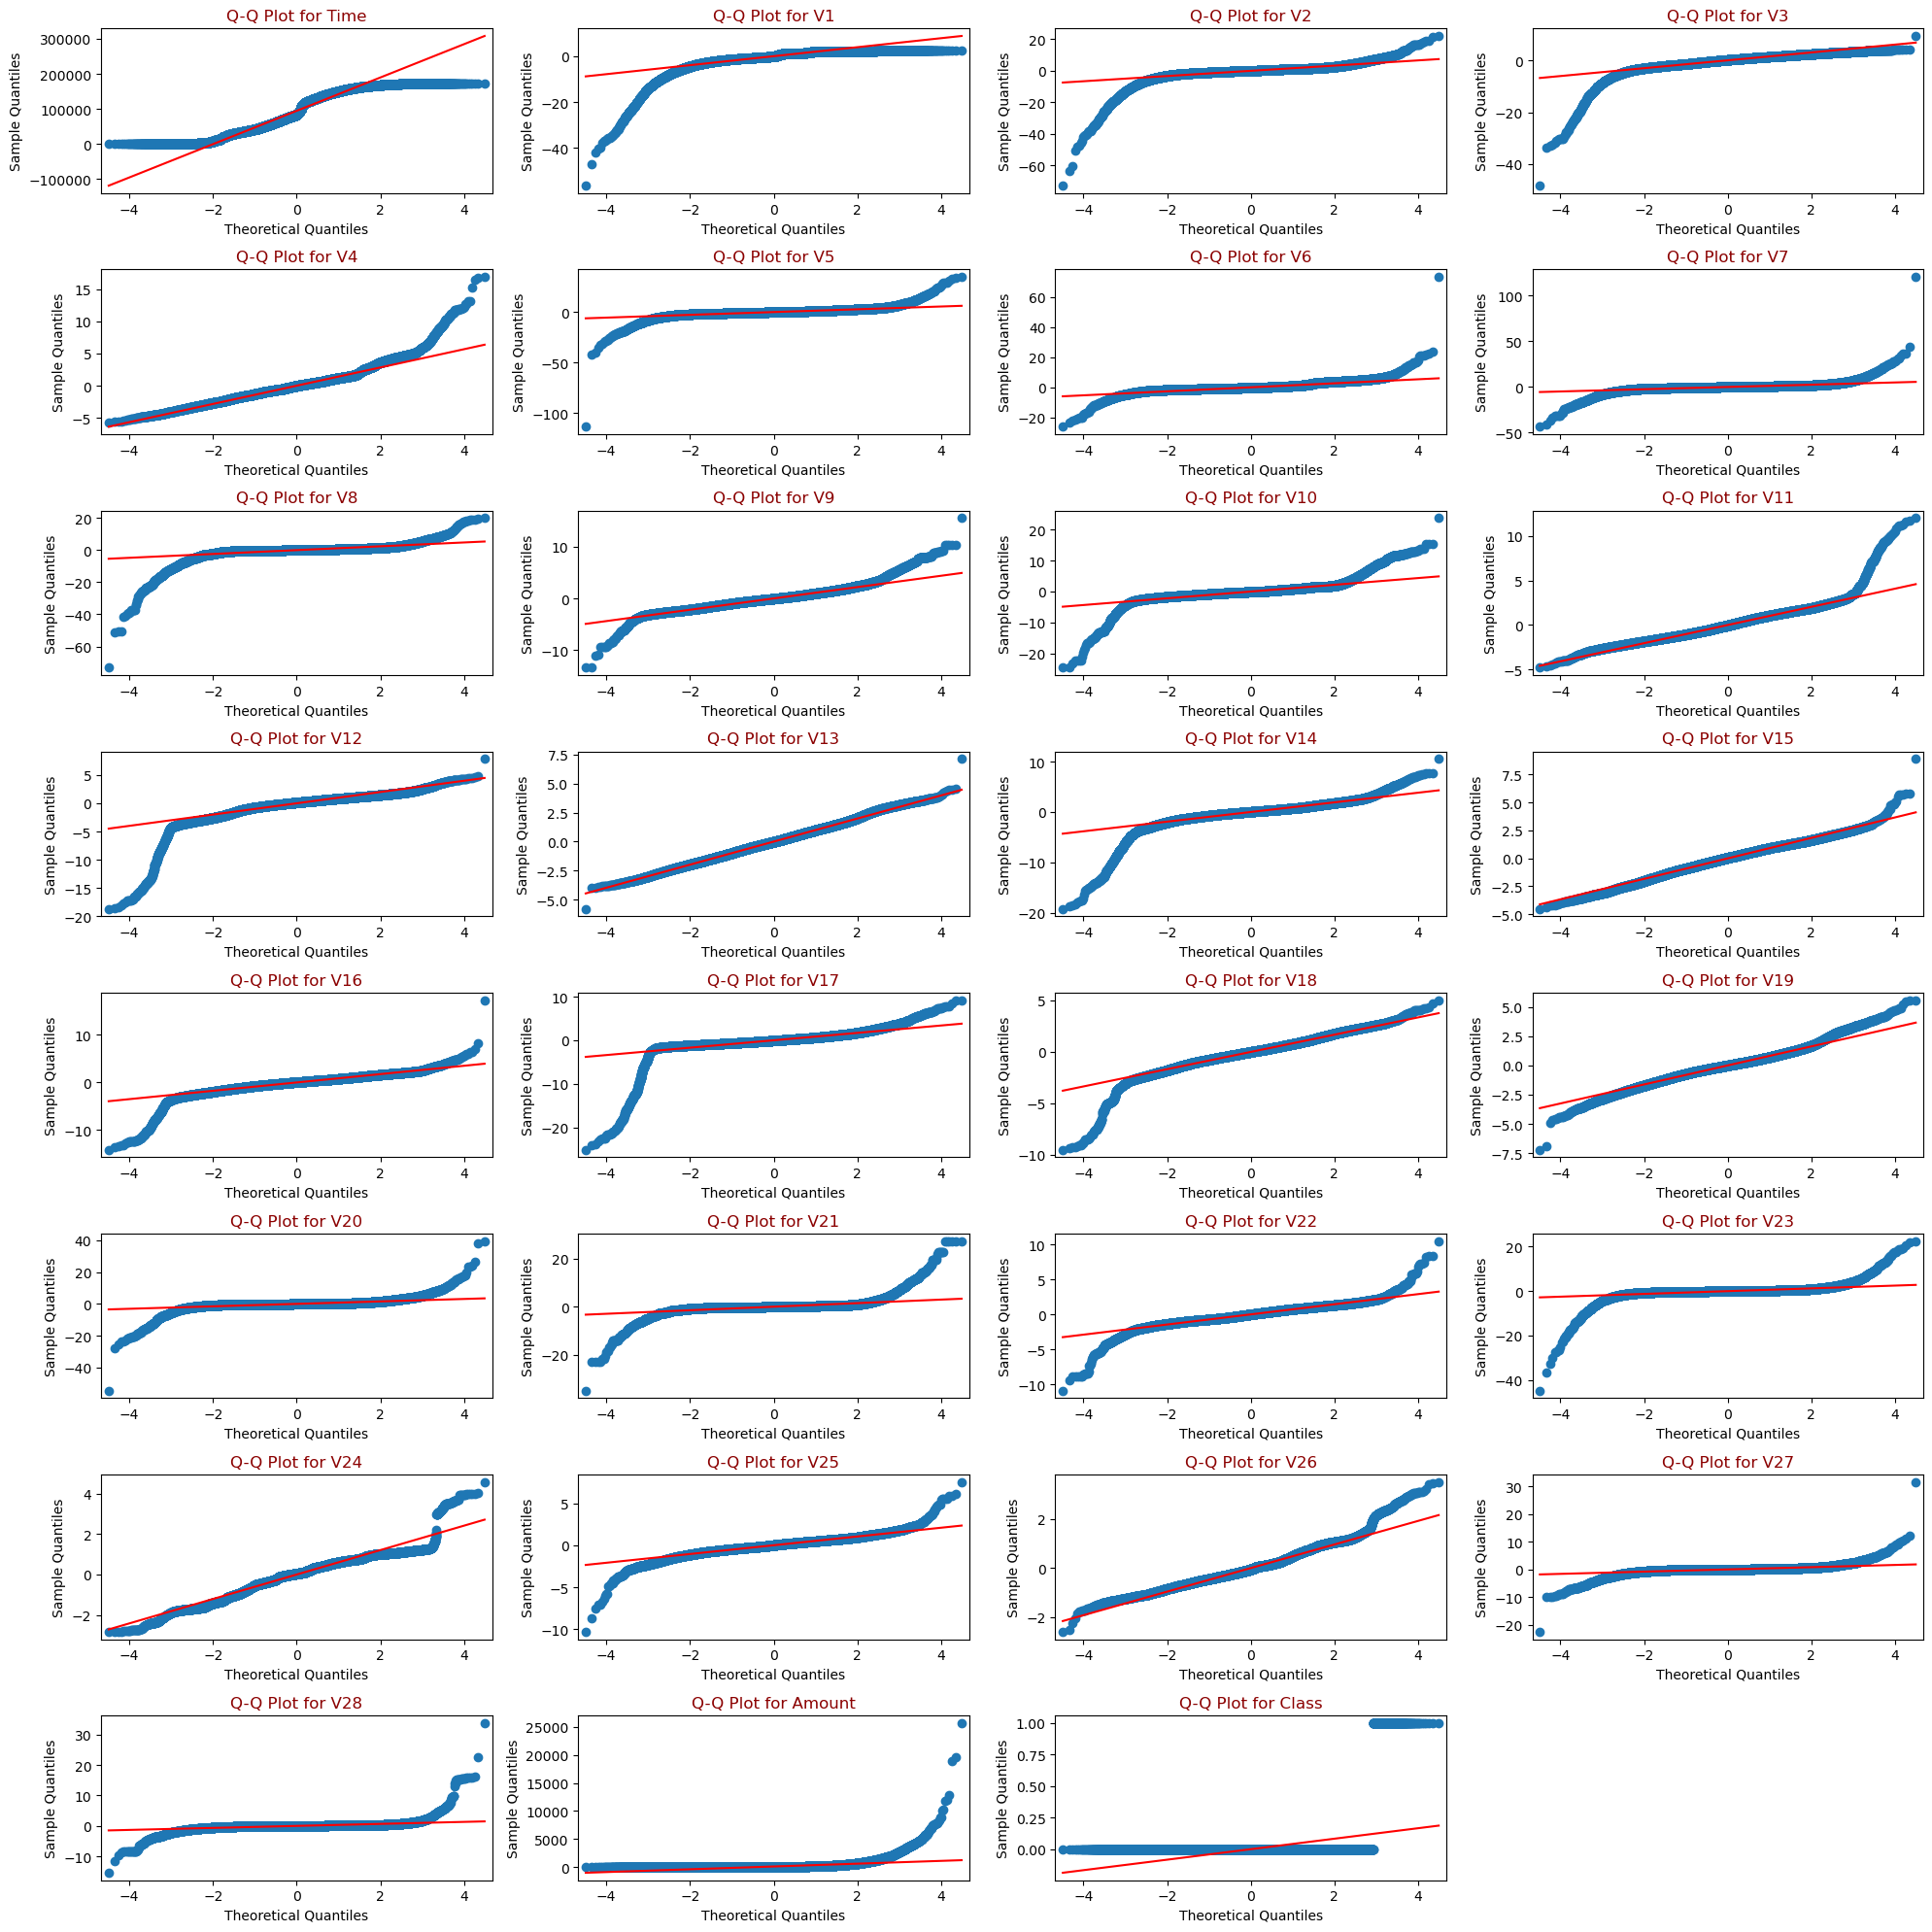

In [9]:
def draw_qq_plots(df, features, rows, columns):
    fig = plt.figure(figsize=(20, 20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, columns, i+1)
        sm.qqplot(df[feature], line='s', ax=ax)
        ax.set_title(f'Q-Q Plot for {feature}', color='DarkRed')
    fig.tight_layout()
    plt.show()

draw_qq_plots(main_df, main_df.columns, 8, 4)


# Data Normalization for Machine Learning
From our above statistical analysis we can see our data is not normalized so we are going to normalize our data.

In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on your dataset
normalized_data = scaler.fit_transform(main_df)

# Convert the normalized data back to a DataFrame
normalized_df = pd.DataFrame(data=normalized_data, columns=main_df.columns)

# Check the first few rows of the normalized DataFrame
normalized_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,-0.041599
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,-0.041599
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,-0.041599
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,-0.041599
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,-0.041599


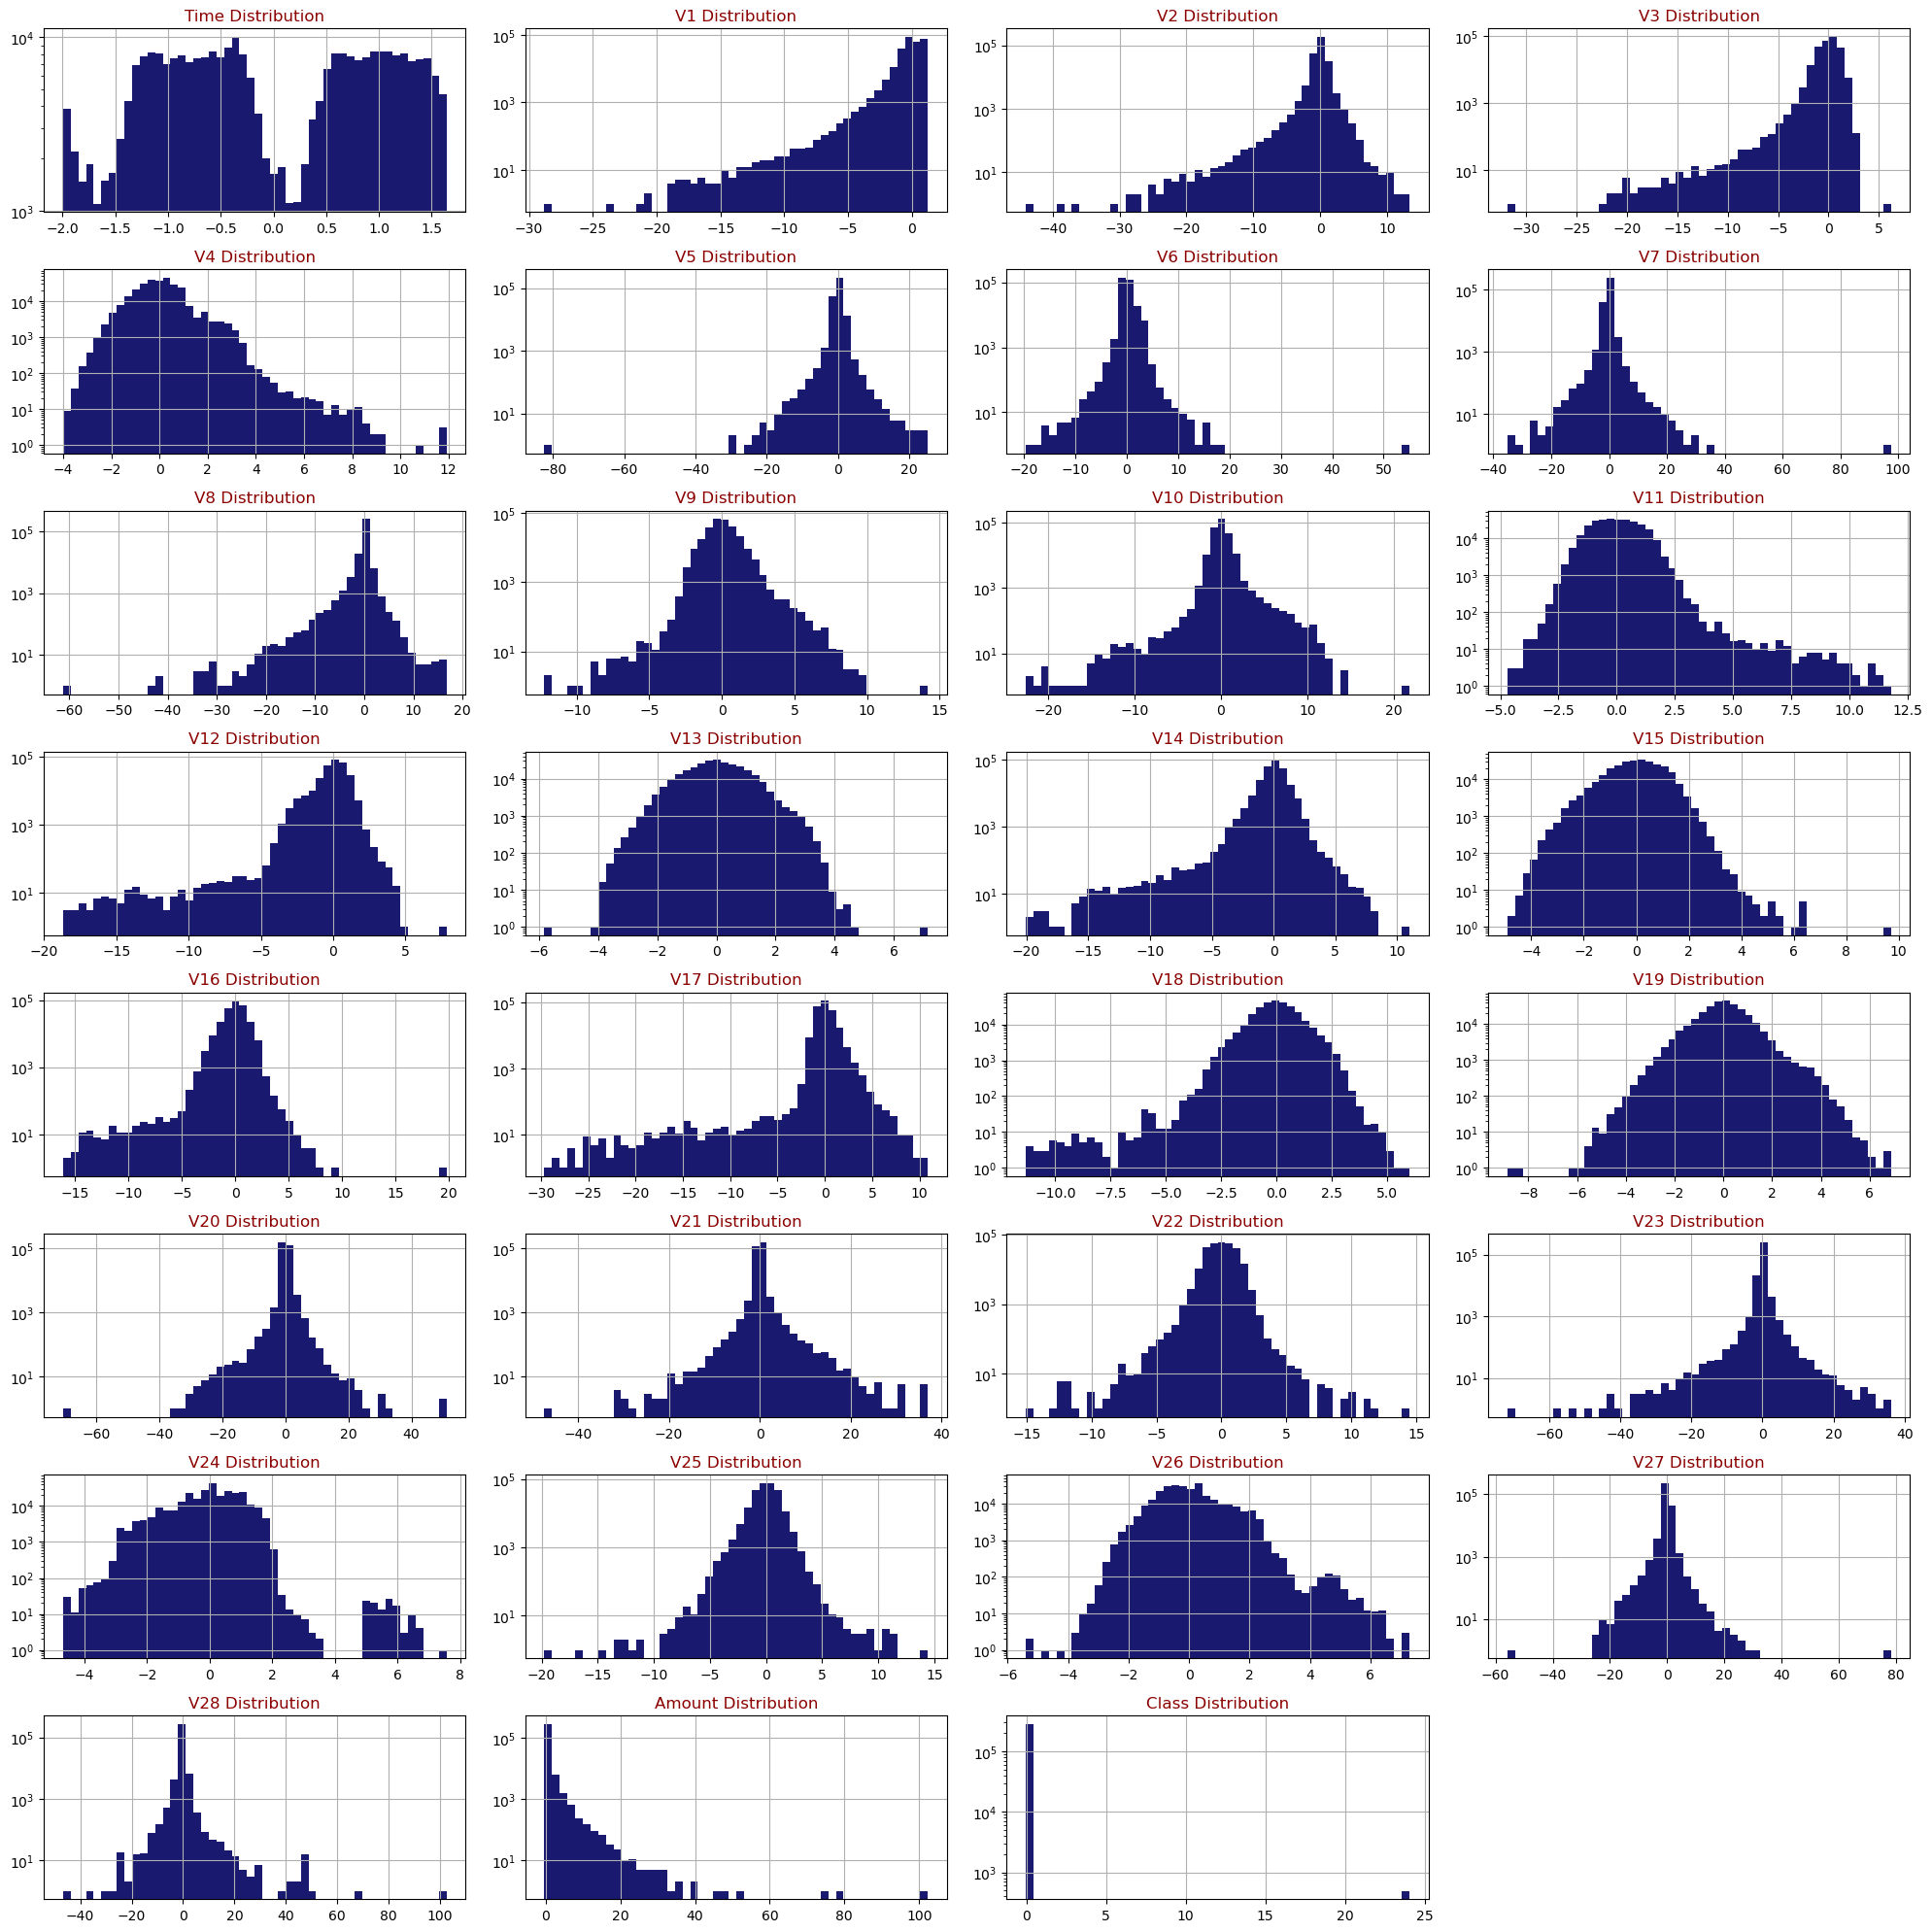

In [11]:
def draw_histograms(df, features, rows, columns):
    fig = plt.figure(figsize=(20, 20))
    for i, features in enumerate(features):
        ax = fig.add_subplot(rows, columns, i+1)
        df[features].hist(bins = 50 , ax = ax, facecolor='midnightblue')
        ax.set_title(features+" Distribution", color="DarkRed")
        ax.set_yscale('log')
    fig.tight_layout()
    plt.show()  
    
draw_histograms(normalized_df, normalized_df.columns, 8, 4)

In [12]:
# Performing the Shapiro-Wilk test for each column in main_df
for column in normalized_df.columns:
    stat, p = shapiro(normalized_df[column])
    print(f'{column}: Statistics={stat}, p={p}')

Time: Statistics=0.9403072595596313, p=0.0
V1: Statistics=0.7989975810050964, p=0.0
V2: Statistics=0.7397158741950989, p=0.0
V3: Statistics=0.9079893827438354, p=0.0
V4: Statistics=0.9692800045013428, p=0.0
V5: Statistics=0.8248799443244934, p=0.0
V6: Statistics=0.8448648452758789, p=0.0
V7: Statistics=0.7248649597167969, p=0.0
V8: Statistics=0.4994257688522339, p=0.0
V9: Statistics=0.9693450331687927, p=0.0
V10: Statistics=0.8146616220474243, p=0.0
V11: Statistics=0.9855819344520569, p=0.0
V12: Statistics=0.8836046457290649, p=0.0
V13: Statistics=0.9989896416664124, p=2.3147049526166136e-31
V14: Statistics=0.8843459486961365, p=0.0
V15: Statistics=0.9936366081237793, p=0.0
V16: Statistics=0.9505929946899414, p=0.0
V17: Statistics=0.7910324335098267, p=0.0
V18: Statistics=0.9847400784492493, p=0.0
V19: Statistics=0.9830102920532227, p=0.0
V20: Statistics=0.5296142101287842, p=0.0
V21: Statistics=0.48562562465667725, p=0.0
V22: Statistics=0.9829753041267395, p=0.0
V23: Statistics=0.4672

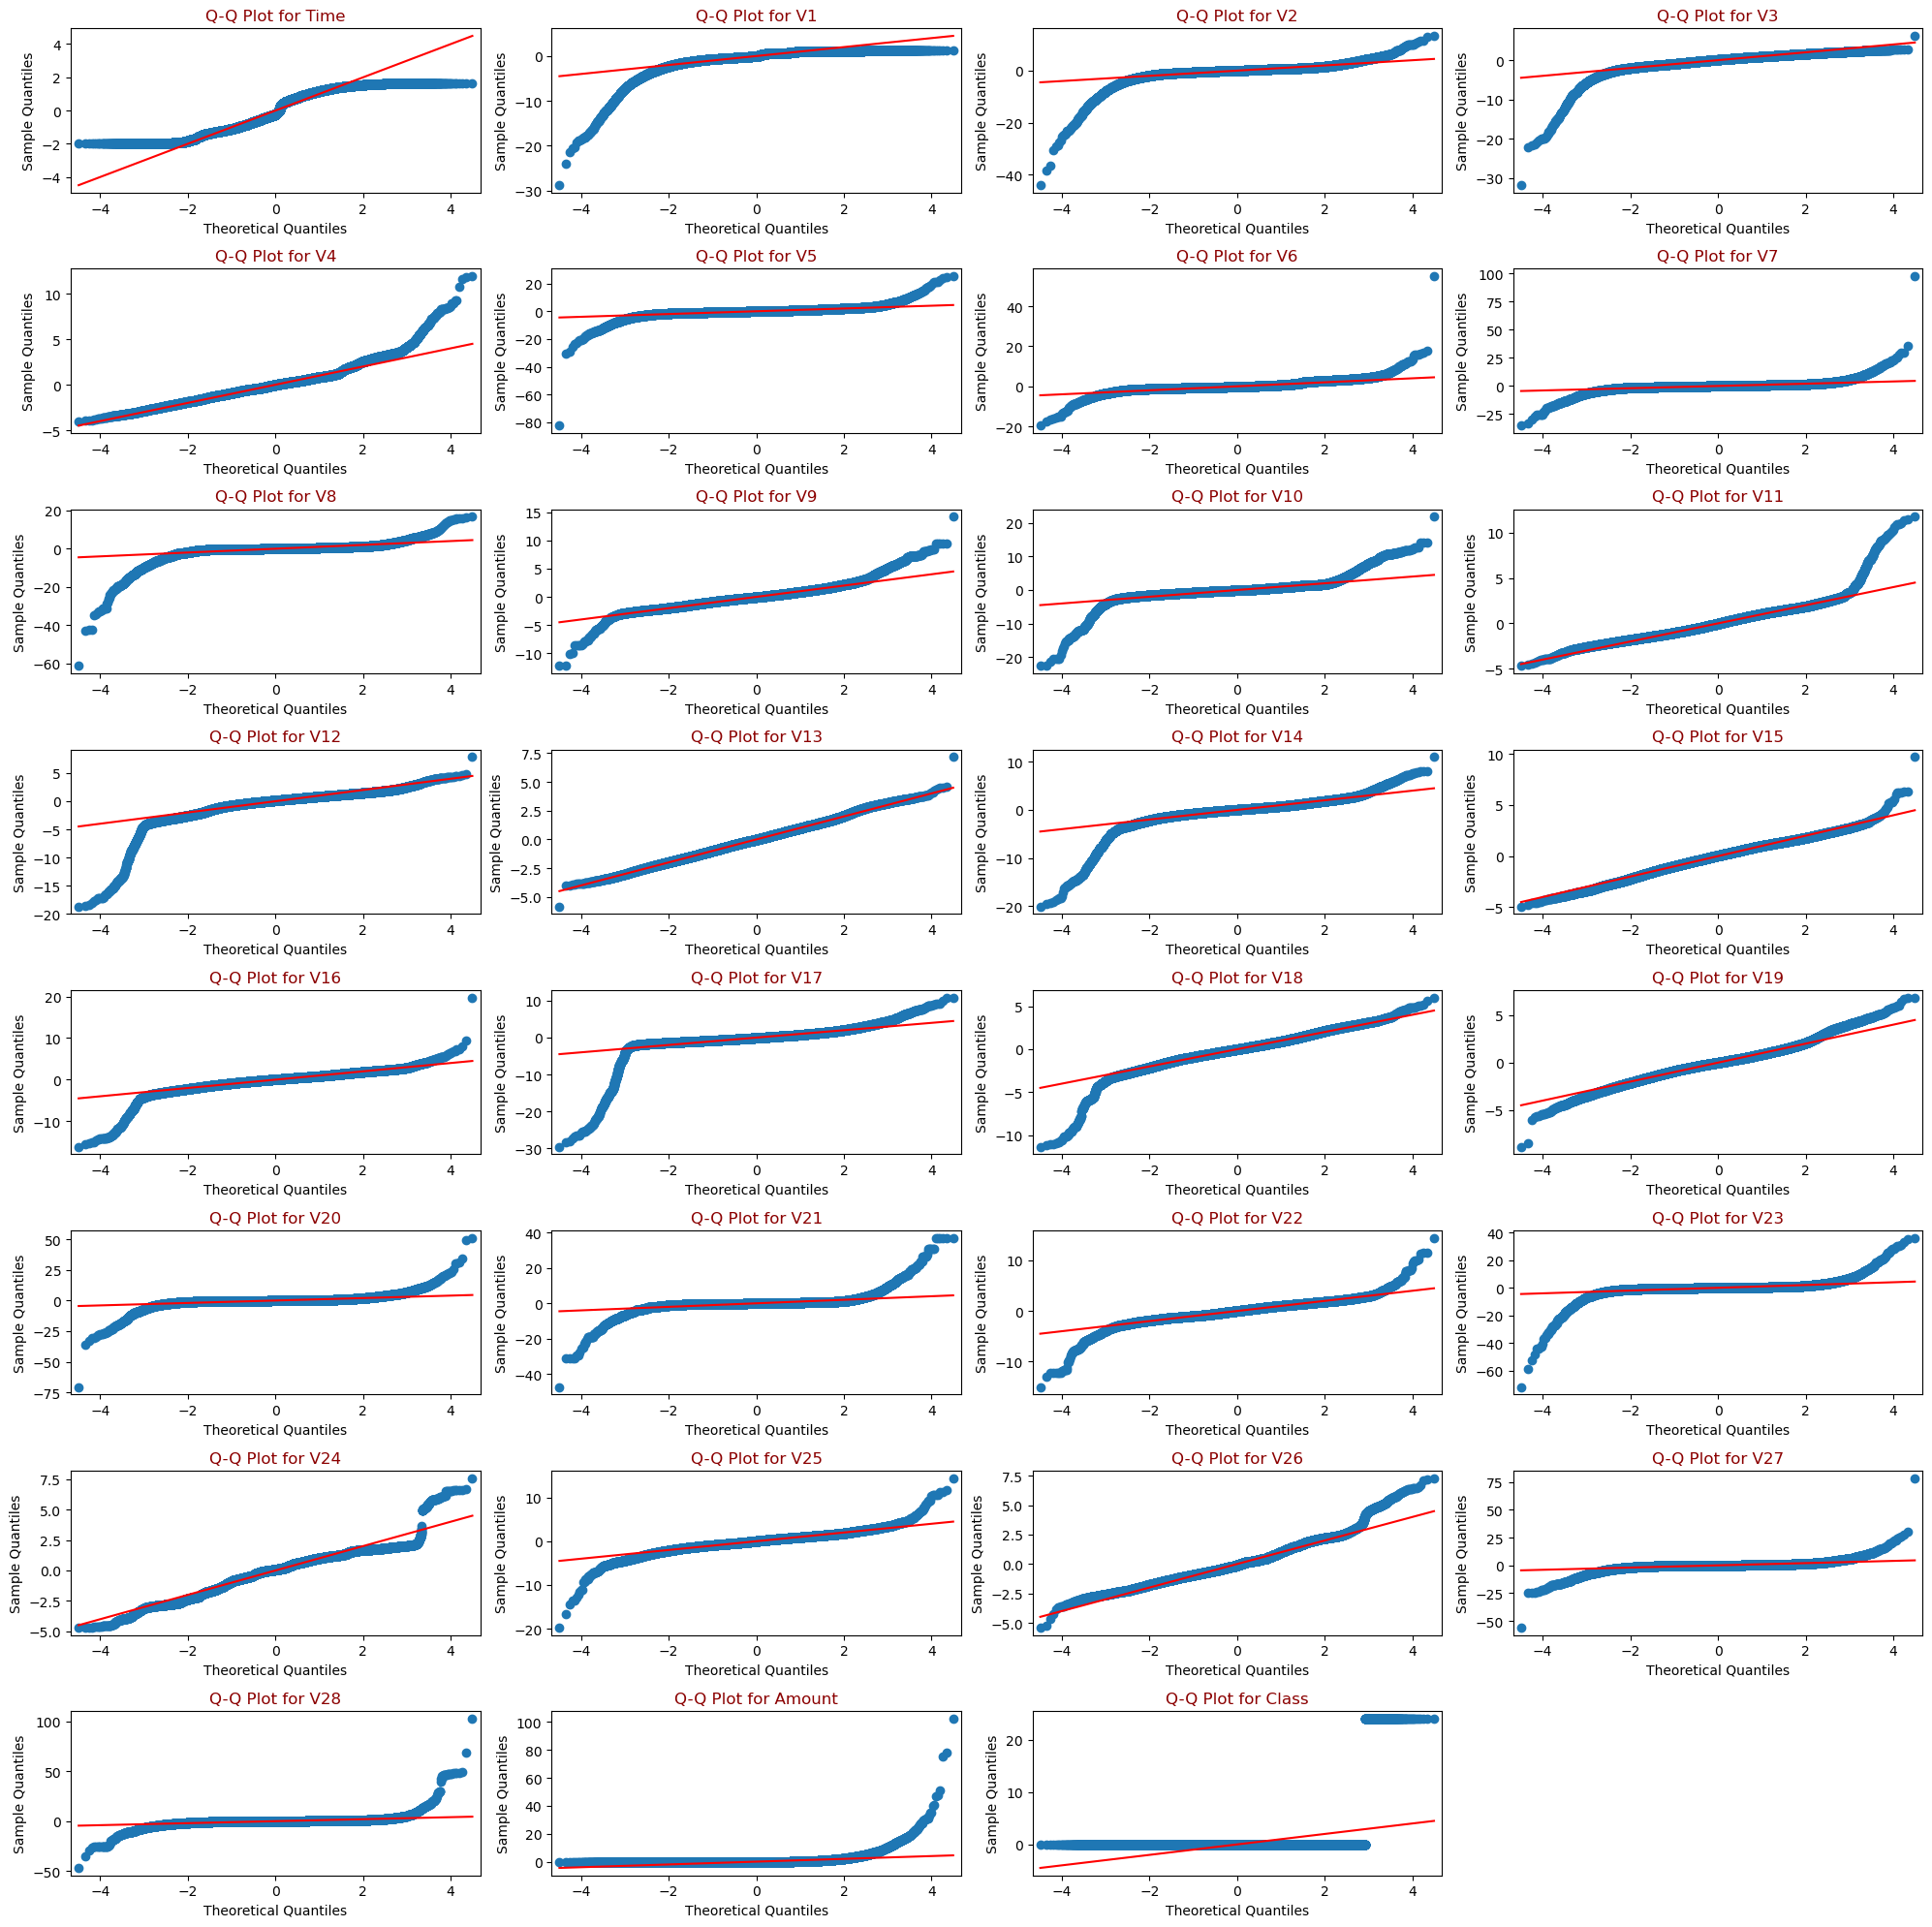

In [13]:
def draw_qq_plots(df, features, rows, columns):
    fig = plt.figure(figsize=(20, 20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, columns, i+1)
        sm.qqplot(df[feature], line='s', ax=ax)
        ax.set_title(f'Q-Q Plot for {feature}', color='DarkRed')
    fig.tight_layout()
    plt.show()

draw_qq_plots(normalized_df, normalized_df.columns, 8, 4)

In [14]:
# Split the dataset into features (X) and the target (y)
X = main_df.drop('Class', axis=1)
y = main_df['Class']

In [16]:
# Splitting the data into trainig and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Applying SMOTE and Tomek Link
smt = SMOTETomek(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

# Defining the hyperparamete grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [17]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

# Get the best hyperparameters
best_rf_classifier = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_rf_classifier.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

In [29]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Defining the number of features to select (N)
N = 10

In [30]:
# Method 1: Mutual Information for feature selection
mi_selector = SelectKBest(mutual_info_classif, k=N)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
X_test_mi = mi_selector.transform(X_test)

In [31]:
# Method 2: SelectKBest (e.g., chi-squared) for feature selection
skb_selector = SelectKBest(k=N)
X_train_skb = skb_selector.fit_transform(X_train, y_train)
X_test_skb = skb_selector.transform(X_test)

In [41]:
# Method 3: Recursive Feature Elimination (RFE) for feature selection
# Fit a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Sort feature indices by importance
selected_feature_indices = np.argsort(feature_importances)[::-1]
selected_feature_indices = selected_feature_indices[selected_feature_indices < X_train.shape[1]]

# Select the top N features
top_N_features = X_train.columns[selected_feature_indices[:N]]


In [36]:
# Train and evaluate a K-Nearest Neighbors (KNN) classifier using each selected feature set
knn = KNeighborsClassifier(n_neighbors=5)

# Add print statements for debugging
print("Fitting KNN with Mutual Information selected features...")
knn.fit(X_train_mi, y_train)
print("Predicting with Mutual Information selected features...")
y_pred_mi = knn.predict(X_test_mi)
accuracy_mi = accuracy_score(y_test, y_pred_mi)
precision_mi = precision_score(y_test, y_pred_mi)
recall_mi = recall_score(y_test, y_pred_mi)
f1_mi = f1_score(y_test, y_pred_mi)
clr_mi = classification_report(y_test, y_pred_mi)
print("Accuracy:", accuracy_mi)
print("Precision:", precision_mi)
print("Recall:", recall_mi)
print("F1 Score:", f1_mi)
print("Classification Report:\n", clr_mi)


# # Evaluate Mutual Information selected features
# knn.fit(X_train_mi, y_train)
# y_pred_mi = knn.predict(X_test_mi)
# accuracy_mi = accuracy_score(y_test, y_pred_mi)
# print(f"Accuracy (Mutual Information): {accuracy_mi:.4f}")

# Evaluate SelectKBest selected features
knn.fit(X_train_skb, y_train)
y_pred_skb = knn.predict(X_test_skb)
accuracy_skb = accuracy_score(y_test, y_pred_skb)
precision_skb = precision_score(y_test, y_pred_skb)
recall_skb = recall_score(y_test, y_pred_skb)
f1_skb = f1_score(y_test, y_pred_skb)
clr_skb = classification_report(y_test, y_pred_skb)
print("Accuracy:", accuracy_skb)
print("Precision:", precision_skb)
print("Recall:", recall_skb)
print("F1 Score:", f1_skb)
print("Classification Report:\n", clr_skb)

# # Evaluate RFE selected features
# knn.fit(X_train_rfe, y_train)
# y_pred_rfe = knn.predict(X_test_rfe)
# accuracy_rfe = accuracy_score(y_test, y_pred_rfe)
# print(f"Accuracy (RFE): {accuracy_rfe:.4f}")

Fitting KNN with Mutual Information selected features...
Predicting with Mutual Information selected features...
Accuracy: 0.9995903701883126
Precision: 0.904
Recall: 0.8308823529411765
F1 Score: 0.8659003831417624
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.90      0.83      0.87       136

    accuracy                           1.00     85443
   macro avg       0.95      0.92      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy: 0.999602073897218
Precision: 0.9047619047619048
Recall: 0.8382352941176471
F1 Score: 0.8702290076335878
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.90      0.84      0.87       136

    accuracy                           1.00     85443
   macro avg       0.95      0.92      0.94     85443
weighted avg       1.00 